In [1]:
#Description: This Program is uses Python to classify images from 4 difrent categories and train a model to predict desired input 

In [2]:
#We import libraries 
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten #core layers
from keras.layers import Convolution2D, MaxPooling2D #keras CNN layers
from keras.layers import CenterCrop, Rescaling #image rescaling and crop tools
from keras.utils import np_utils
import matplotlib.pyplot as plt
import numpy as np 
import cv2 as cv
import os 
import matplotlib.pyplot as plt
import numpy as np 
import cv2
import os 

In [3]:
#CHANGE DIRECTORY path to dataset
os.chdir(r'/content/drive/MyDrive/Colab Notebooks')

img_height = 150
img_width = 150
batch_size = 32

#Define training and validation datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    "DataSet",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    "DataSet",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 889 files belonging to 4 classes.
Using 712 files for training.
Found 889 files belonging to 4 classes.
Using 177 files for validation.


In [4]:
#Print the dataset class names
class_names = train_ds.class_names
print(class_names)

['bloodborne', 'dark souls', 'elden ring', 'sekiro ']


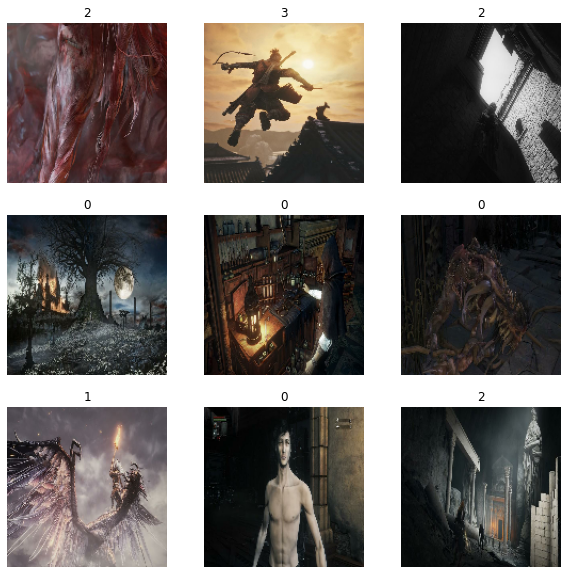

In [5]:
#Visualize the data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [6]:
#Normalization of the data
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0014902153 1.0


In [7]:
#We augment the data to avoid overfitting the model
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

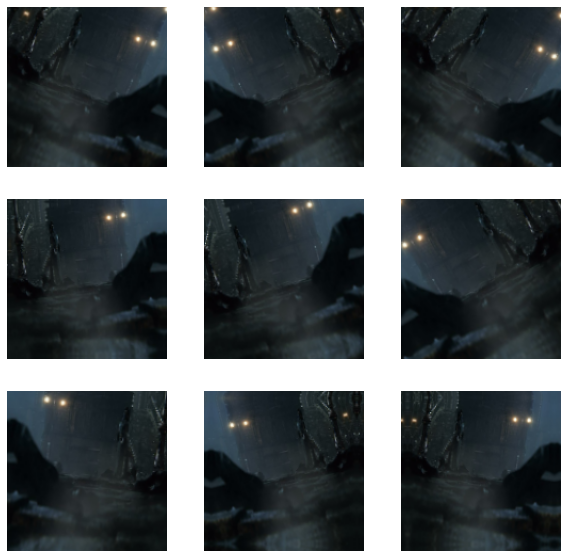

In [8]:
#Visualize the augmented data 
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [9]:
#We call batches of the data 
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 150, 3)
(32,)


In [10]:
#Define the model
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [11]:
#compile the model 
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
#View all the layers of the network
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                  

In [21]:
#Train the model
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
23/23 [==============================] - 2s 82ms/step - loss: 0.0497 - accuracy: 0.9846 - val_loss: 4.9153 - val_accuracy: 0.4576
Epoch 2/10
23/23 [==============================] - 2s 81ms/step - loss: 0.0509 - accuracy: 0.9846 - val_loss: 4.5594 - val_accuracy: 0.4915
Epoch 3/10
23/23 [==============================] - 2s 81ms/step - loss: 0.0419 - accuracy: 0.9846 - val_loss: 5.3992 - val_accuracy: 0.4633
Epoch 4/10
23/23 [==============================] - 2s 82ms/step - loss: 0.0760 - accuracy: 0.9803 - val_loss: 4.7556 - val_accuracy: 0.4407
Epoch 5/10
23/23 [==============================] - 2s 81ms/step - loss: 0.1015 - accuracy: 0.9677 - val_loss: 4.0192 - val_accuracy: 0.5311
Epoch 6/10
23/23 [==============================] - 2s 80ms/step - loss: 0.0500 - accuracy: 0.9789 - val_loss: 4.4845 - val_accuracy: 0.5367
Epoch 7/10
23/23 [==============================] - 2s 81ms/step - loss: 0.0728 - accuracy: 0.9789 - val_loss: 4.1576 - val_accuracy: 0.5141
Epoch 8/10
23

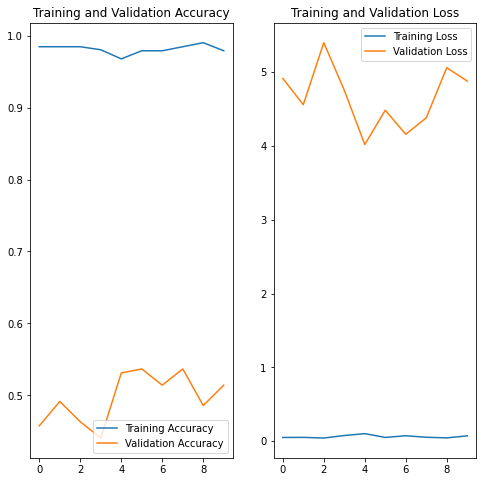

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#As we can se there is a large diffrence between the training accuracy and the validation accurary
#Further development of the model to cause less overfitting or perhaps a larger training_dataset could be collected using data-scraping
#Concluded for now.  